In [2]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [3]:
train_dir = '/kaggle/input/chest-xray-enhanced/chest_xray_Enhanced/train'
test_dir = '/kaggle/input/chest-xray-enhanced/chest_xray_Enhanced/test'
val_dir = '/kaggle/input/chest-xray-enhanced/chest_xray_Enhanced/val'

In [4]:
image_size = 160
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size = batch_size,
                                                                 shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=(image_size, image_size),
                                                               batch_size = batch_size,
                                                               shuffle = False)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [5]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 160, 160, 3)
(32,)


In [6]:
class_names = train_data.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


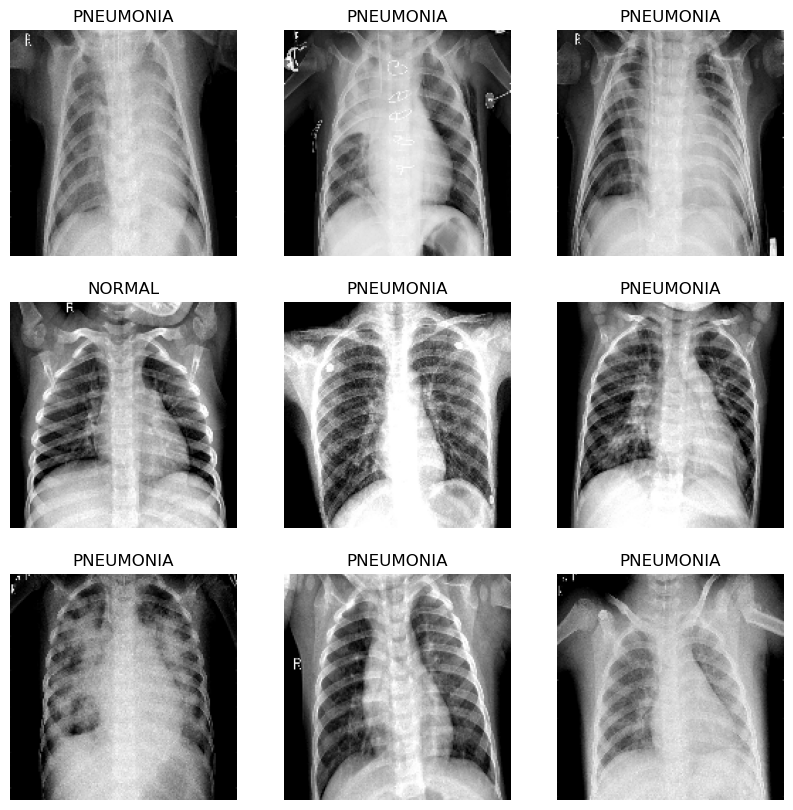

In [7]:
plt.figure(figsize = (10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [8]:
image_batch

<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
array([[[[3.5099697e+01, 3.5099697e+01, 3.5099697e+01],
         [3.2162502e+01, 3.2162502e+01, 3.2162502e+01],
         [3.3720360e+01, 3.3720360e+01, 3.3720360e+01],
         ...,
         [4.3359375e+01, 4.3359375e+01, 4.3359375e+01],
         [4.4469688e+01, 4.4469688e+01, 4.4469688e+01],
         [3.6743774e+01, 3.6743774e+01, 3.6743774e+01]],

        [[4.0088409e+01, 4.0088409e+01, 4.0088409e+01],
         [3.7258976e+01, 3.7258976e+01, 3.7258976e+01],
         [3.5042042e+01, 3.5042042e+01, 3.5042042e+01],
         ...,
         [4.1598583e+01, 4.1598583e+01, 4.1598583e+01],
         [4.2255867e+01, 4.2255867e+01, 4.2255867e+01],
         [3.7743774e+01, 3.7743774e+01, 3.7743774e+01]],

        [[4.5795265e+01, 4.5795265e+01, 4.5795265e+01],
         [4.2781250e+01, 4.2781250e+01, 4.2781250e+01],
         [3.5601318e+01, 3.5601318e+01, 3.5601318e+01],
         ...,
         [3.9788818e+01, 3.9788818e+01, 3.9788818e+01],

In [9]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [10]:
train = train_data.map(format_example)
validation = val_data.map(format_example)



In [11]:
for normal_batch, normal_label_batch in train:
  print(normal_batch.shape)
  print(normal_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [12]:
normal_image = normal_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(normal_image), np.max(normal_image))

-1.0 0.9948529


In [13]:
IMG_SHAPE = (image_size, image_size, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
base_model.trainable = True

In [19]:
len(base_model.layers)

154

In [20]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [21]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer                     
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [23]:
learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)


Epoch 1/10
163/163 [==============================] - 119s 691ms/step - loss: 0.2833 - accuracy: 0.8656 - val_loss: 0.5336 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 112s 684ms/step - loss: 0.1216 - accuracy: 0.9572 - val_loss: 0.6274 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 113s 690ms/step - loss: 0.0828 - accuracy: 0.9724 - val_loss: 0.6392 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 119s 722ms/step - loss: 0.0579 - accuracy: 0.9804 - val_loss: 0.7212 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 114s 695ms/step - loss: 0.0537 - accuracy: 0.9826 - val_loss: 0.7793 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 113s 689ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.7520 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 113s 686ms/step - loss: 0.0267 - accuracy: 0.9931 - val_loss: 0.4884 -

In [25]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

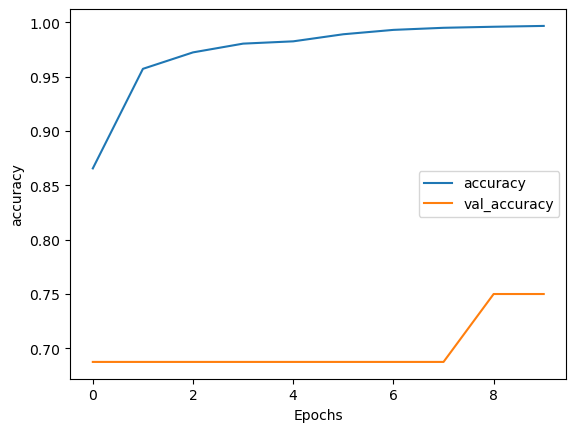

In [26]:
plot_graghs(history, 'accuracy')

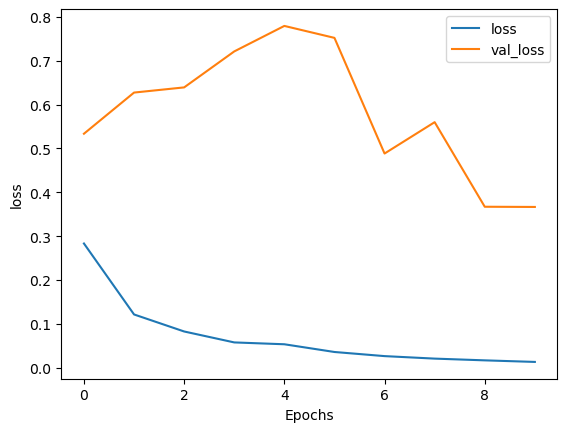

In [27]:
plot_graghs(history, 'loss')

In [28]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle=False
)

Found 624 files belonging to 2 classes.


In [29]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

20/20 [==============================] - 10s 467ms/step - loss: 1.2353 - accuracy: 0.6394
Test loss, Test accuracy :  [1.2353483438491821, 0.6394230723381042]
